Это вторая версия кода, прошлую я переосмыслил и тут будет более качественное решение.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder

NODE: возможно лучше стоит GradientBoost использовать, я его попробую, но позже.

<Axes: >

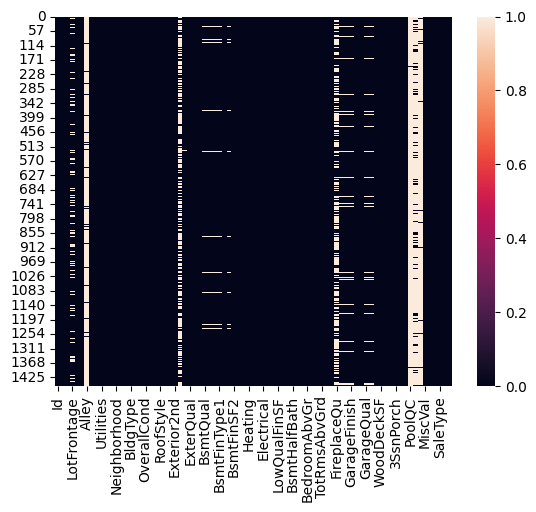

In [88]:
df = pd.read_csv(r"data\train.csv")
sns.heatmap(data=df.isnull())

In [89]:
missing_col_sum = df.isnull().sum()

missing_cols = df.columns[df.isnull().sum() > 0].tolist()
missing_col_less_than_10_per = missing_col_sum[
    (missing_col_sum > 0) & (missing_col_sum < len(df) * 0.1)
]
print(missing_cols, '\n')
print(missing_col_less_than_10_per)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 

MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64


Тут выдается непонятная ошибка со столбцов, хотя в дальнейшем обрабатывается правильно, поэтому я обернул код в try\except 

In [90]:
df = df.drop(columns=missing_cols)
df = df.drop(columns=["Id",])
try: 
    for col in missing_col_less_than_10_per.index.tolist():
        if df[col].dtype in ["int64", "float64"]:
            df[col].fillna(df[col].mean(), inplace = True)
        else:
            df[col].fillna(df[col].mode()[0], inplace = True)
except:
    pass

<Axes: >

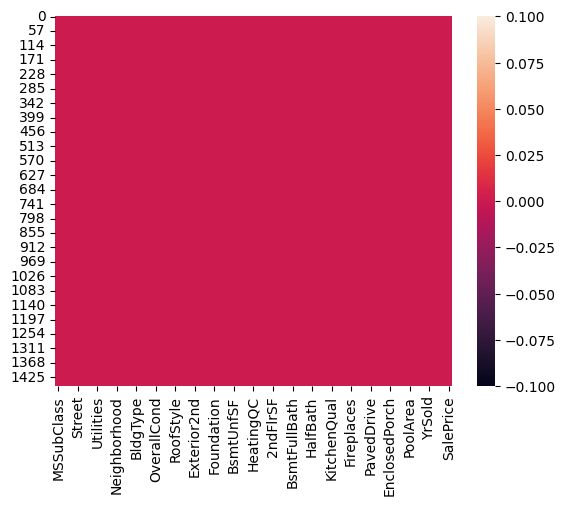

In [91]:
sns.heatmap(data = df.isnull())

Произведем отбор признаков, для начала преобразуем признаки с помощью lavel\ordinal\one-hot encoders 

In [99]:
num_cols = []
categorical_cols = []

for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        num_cols.append(col)
    else:
        categorical_cols.append(col)
    
print(f"num_col: {num_cols}")
print(f"categotical_col: {categorical_cols}")

num_col: ['MSSubClass', 'LotArea', 'LotShape', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
categotical_col: ['LandContour', 'Utilities', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf',

Используем encoders для признаков

In [93]:
df = pd.get_dummies(df, columns=['MSZoning', 'Street', 'LotConfig', 'BldgType', 'HouseStyle', 
                                 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 
                                 'PavedDrive', 'SaleType', 'SaleCondition'], drop_first=True)

ordinal_cols = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional']
ordinal_mapping = [['Reg', 'IR1', 'IR2', 'IR3'], 
                   ['Gtl', 'Mod', 'Sev'], 
                   ['Ex', 'Gd', 'TA', 'Fa'], 
                   ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
                   ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
                   ['Ex', 'Gd', 'TA', 'Fa'], 
                   ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev']]

encoder = OrdinalEncoder(categories=ordinal_mapping)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

label_cols = ['Neighborhood', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])
